In [32]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
import json
import time
import os
import sys
sys.path.append("../..")

import scipy
from scipy.stats import sem
from scipy.io import loadmat

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import math
import tensorflow as tf
import gpflow

from tqdm.notebook import tqdm
import geopandas as gpd
from shapely.geometry import Polygon, Point
import contextily as ctx
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [34]:
# Load the data. Please email the corresponding author for access to the data.
data = loadmat('../../data/dr_paper/EVIVOD_Zhu.mat')
lonLat = loadmat('../../data/dr_paper/latlon_allcrops.mat', squeeze_me=True)

## Data Processing

In [35]:
df = gpd.GeoDataFrame(pd.DataFrame(np.zeros((data["data"]["Y"][0][0].shape[0], 1)), columns=["yield"]))
df["yield"] = data["data"]["Y"][0][0][:,0]
df.crs = {'init':"epsg:4326"}

<ipython-input-35-ac4b3f930132>:3: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  df.crs = {'init':"epsg:4326"}
/home/hbz15/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [36]:
# Check which counties are Polygons

geometry = []
for i in range(385):
    if type(lonLat["lon_county"][i][0]) == np.float64:
        length = 1
    else:
        length = lonLat["lon_county"][i][0].shape[0]
#     print(length)
    if length == 1:
        polygon_geom = Point(lonLat["lon_county"][i][0], lonLat["lat_county"][i][0])
    else:
        polygon_geom = Polygon(zip(lonLat["lon_county"][i][0][:-1], lonLat["lat_county"][i][0][:-1]))
    geometry.append(polygon_geom)
# plt.colorbar()

In [37]:
# Only use data presented in Polygon type

df.geometry = geometry
df["type"] = df["geometry"].apply(lambda v: isinstance(v, Polygon))
df = df[df["type"]]

## Calculate the max number of items in a bag

This step ensures later the ability for mini-batch training for MVBAgg

In [38]:
max_VOD = 0
max_EVI = 0
for i in df.index.values:
    if type(data["data"]["EVI"][0][0][i][0]) == np.float64:
        EVI_length = 1
    else:
        EVI_length = data["data"]["EVI"][0][0][i][0][:-1].shape[0]
        
    if type(data["data"]["VOD"][0][0][i][0]) == np.float64:
        VOD_length = 1
    else:
        VOD_length = data["data"]["VOD"][0][0][i][0][:-1].shape[0]
    max_EVI = max(max_EVI, EVI_length)
    max_VOD = max(max_VOD, VOD_length)
#     print(EVI_length, VOD_length)
dim_VOD = 213
dim_EVI = 13

## Read out the dataset from the `.mat` file and put into a dictionary with keys being the output label `i` 


In [39]:
def create_data_dict(data, indices, max_VOD, max_EVI):
    """Put the dataset into a dictionary by:

    - Concatenating the EVI and VOD covariates
    - Setting weights to be $1/N_a$ - uniform weights
    - 

    Args:
        data ([type]): [description]
        indices ([type]): [description]
        max_VOD ([type]): [description]
        max_EVI ([type]): [description]
    """
    dict_data = {}

    for i in indices:
        x_VOD = np.zeros((max_VOD, 213))
        x_EVI = np.zeros((max_EVI, 13))
        if type(data["data"]["EVI"][0][0][i][0]) == np.float64:
            x_EVI[:1] = data["data"]["EVI"][0][0][i][0, :13]
            EVI_length = 1
        else:
            EVI_length = int(data["data"]["EVI"][0][0][i][0][:-1].shape[0])
            x_EVI[:EVI_length] = data["data"]["EVI"][0][0][i][0][:-1, :13]
            
        if type(data["data"]["VOD"][0][0][i][0]) == np.float64:
            x_VOD[:1] = data["data"]["VOD"][0][0][i][0][:, :213]
            VOD_length = 1
        else:
            VOD_length = int(data["data"]["VOD"][0][0][i][0][:-1].shape[0])
            x_VOD[:VOD_length] = data["data"]["VOD"][0][0][i][0][:-1, :213]
        
        weights_VOD = np.zeros((max_VOD, 1))
        weights_EVI = np.zeros((max_EVI, 1))
        weights_VOD[: VOD_length, 0] = 1/VOD_length
        weights_EVI[: EVI_length, 0] = 1/EVI_length
#         y = np.log(data["data"]["Y"][0][0][i][0])
        y = data["data"]["Y"][0][0][i][0]
#         print(VOD_length, EVI_length)

        dict_data[str(i)] = {
            "VOD_length": VOD_length,
            "EVI_length": EVI_length,
            "weights_VOD": weights_VOD,
            "weights_EVI": weights_EVI,
            "x_VOD": x_VOD,
            "x_EVI": x_EVI,
            "y": np.expand_dims(y, 0),        
        }
    return dict_data

## Shuffle the county index

In [40]:
indices = list(df.index.values)
random.seed(1)
shuffled_indices = random.sample(indices, 375)

## KRR Experiments

In [41]:
from src.krr import LRe, KRRe
from src.bagData import BagData, BagDataGenerator
from typing import Callable
from sklearn.cluster import KMeans

class MultiResolutionBagData(BagData):
    """
    """

    def __init__(self, bag_data: dict) -> None:
        super().__init__(bag_data)
        
    def _create_subset(
        self, initial_num_items: int, initialisationMethod: Callable = None
    ) -> None:

        raise NotImplementedError()
    def __getitem__(self, bag):
        """
            bag: bag index from indexing system
        """
        return (
            self.bag_data[bag]["VOD_length"],
            self.bag_data[bag]["EVI_length"],
            self.bag_data[bag]["weights_VOD"],
            self.bag_data[bag]["weights_EVI"],
            self.bag_data[bag]["x_VOD"],
            self.bag_data[bag]["x_EVI"],
            self.bag_data[bag]["y"],
        )
    
class MultiResolutionBagDataGenerator(MultiResolutionBagData):
    def __init__(self, bag_data: dict, num_inducing_u1: int = 1, num_inducing_u2: int = 1) -> None:
        super().__init__(bag_data)
        self.num_inducing_u1 = num_inducing_u1
        self.num_inducing_u2 = num_inducing_u2
        self.kmeans_1 = KMeans(n_clusters=num_inducing_u1)
        self.kmeans_2 = KMeans(n_clusters=num_inducing_u2)
        self.dim_1 = self.__getitem__(self.bags[0])[-3].shape[1]
        self.dim_2 = self.__getitem__(self.bags[0])[-2].shape[1]

    def gen_bags(self):
        for bag in self.bags:
            yield self.__getitem__(bag)

    def gen_inducing(self) -> np.ndarray:
        landmark_points_u1 = np.zeros(
            [self.num_bags * self.num_inducing_u1, self.dim_1]
        )
        landmark_points_u2 = np.zeros(
            [self.num_bags * self.num_inducing_u1, self.dim_2]
        )
        for i, bag in enumerate(self.bags):
            landmark_points_u1[
                i * self.num_inducing_u1 : i * self.num_inducing_u1
                + self.num_inducing_u1,
                :,
            ] = self.kmeans_1.fit(
                self.__getitem__(bag)[-3]
            ).cluster_centers_
            
            landmark_points_u2[
                i * self.num_inducing_u2 : i * self.num_inducing_u2
                + self.num_inducing_u2,
                :,
            ] = self.kmeans_2.fit(
                self.__getitem__(bag)[-2]
            ).cluster_centers_
        return landmark_points_u1, landmark_points_u2

In [42]:
class MultiResolutionLRe(LRe):
    def __init__(self, train_bag: BagData, kernel: gpflow.kernels.Kernel, kernel_2: gpflow.kernels.Kernel, lmbda: np.float = 0.1) -> None:
        super().__init__(train_bag, kernel, lmbda)
        self.kernel_2 = kernel_2
        
        
    def bag_cov(self, bag_data1: BagData, bag_data2: BagData = None) -> np.ndarray:
        bags1 = bag_data1.bags
        if bag_data2:
            bags2 = bag_data2.bags
        else:
            bag_data2 = bag_data1
            bags2 = bag_data1.bags

        K = np.zeros((len(bags1), len(bags2)))

        for i, bag1 in tqdm(enumerate(bags1)):
            for j, bag2 in enumerate(bags2):
                VOD_length_i, EVI_length_i, _, _, x_VOD_i, x_EVI_i, _ = bag_data1[bag1]
                VOD_length_j, EVI_length_j, _, _, x_VOD_j, x_EVI_j, _ = bag_data2[bag2]
                x_VOD_i, x_EVI_i = x_VOD_i[:VOD_length_i, :], x_EVI_i[:EVI_length_i, :]
                x_VOD_j, x_EVI_j = x_VOD_j[:VOD_length_j, :], x_EVI_j[:EVI_length_j, :]
                K[i, j] = np.mean(self.kernel(x_VOD_i, x_VOD_j)) + np.mean(self.kernel_2(x_EVI_i, x_EVI_j))
        return K


class MultiResolutionKRRe(KRRe):
    def __init__(self, train_bag: BagData, kernel: gpflow.kernels.Kernel, kernel_2: gpflow.kernels.Kernel, lmbda: np.float = 0.1) -> None:
        super().__init__(train_bag, kernel, lmbda)
        self.kernel_2 = kernel_2
        
        
    def bag_cov(self, bag_data1: BagData, bag_data2: BagData = None, median_heuristic=False) -> np.ndarray:
        bags1 = bag_data1.bags
        if bag_data2:
            bags2 = bag_data2.bags
        else:
            bag_data2 = bag_data1
            bags2 = bag_data1.bags

        K = np.zeros((len(bags1), len(bags2)))

        for i, bag1 in tqdm(enumerate(bags1)):
            for j, bag2 in enumerate(bags2):
                VOD_length_i, EVI_length_i, _, _, x_VOD_i, x_EVI_i, _ = bag_data1[bag1]
                VOD_length_j, EVI_length_j, _, _, x_VOD_j, x_EVI_j, _ = bag_data2[bag2]
                x_VOD_i, x_EVI_i = x_VOD_i[:VOD_length_i, :], x_EVI_i[:EVI_length_i, :]
                x_VOD_j, x_EVI_j = x_VOD_j[:VOD_length_j, :], x_EVI_j[:EVI_length_j, :]
                K[i, j] = np.mean(self.kernel(x_VOD_i, x_VOD_i) + self.kernel_2(x_EVI_i, x_EVI_i)) - 2*np.mean(self.kernel(x_VOD_i, x_VOD_j) + self.kernel_2(x_EVI_i, x_EVI_j)) + np.mean(self.kernel(x_VOD_j, x_VOD_j) + self.kernel_2(x_EVI_j, x_EVI_j))
        if median_heuristic == True:
            self.lengthscale_rho = np.quantile(scipy.spatial.distance.pdist(np.expand_dims(K.flatten(), axis=1), metric="euclidean"), 0.5)
        return self.scale_rho * np.exp(-K / (2 * self.lengthscale_rho))


RMSE:  0.05998707625024107



RMSE:  0.07522063031375054



RMSE:  0.08442203044609167



RMSE:  0.0715762221993049



RMSE:  0.08455036804953203
CV-RMSE: 0.07515126545178405, CV-MAPE: 0.08461798140632588


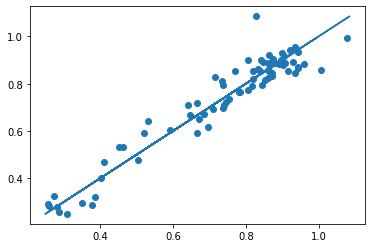

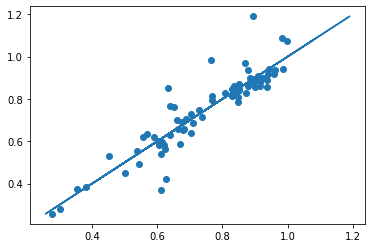

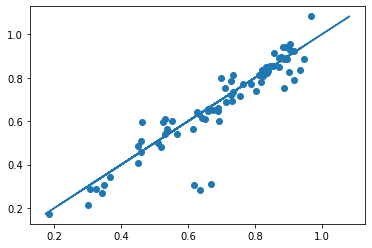

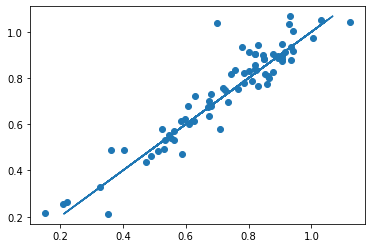

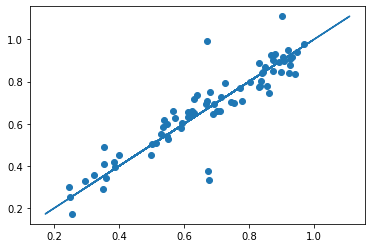

In [43]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
# KRR
RMSE = []
MAPE = []
training_time = []
for k in range(5):
    train_indices = shuffled_indices[:k*75] + shuffled_indices[(k+1)*75:]
    test_indices = shuffled_indices[k*75: (k+1)*75]
    train_set = create_data_dict(data, train_indices, max_VOD, max_EVI)
    test_set = create_data_dict(data, test_indices, max_VOD, max_EVI)

    # form dataset with centroids
    keys = list(train_set.keys())
    train_bag = MultiResolutionBagDataGenerator(train_set)
    x1 = np.zeros((0, train_bag.dim_1))
    x2 = np.zeros((0, train_bag.dim_2))
    for i, bag in enumerate(train_bag.bags):
        if train_bag[bag][1] < 10:
            num_VOD = train_bag[bag][1]
        else:
            num_VOD = 10
        x1 = np.vstack([x1, train_bag[bag][-3][:num_VOD]])
        x2 = np.vstack([x2, train_bag[bag][-2][:num_VOD]])
    x1_distances = scipy.spatial.distance.pdist(x1, metric='euclidean')
    x2_distances = scipy.spatial.distance.pdist(x2, metric='euclidean')
    x1_median = np.quantile(x1_distances, 0.5)
    x2_median = np.quantile(x2_distances, 0.5)
    
    k1 = gpflow.kernels.SquaredExponential(lengthscales=x1_median)
    k2 = gpflow.kernels.SquaredExponential(lengthscales=x2_median)
#     k1 = gpflow.kernels.Linear()
#     k2 = gpflow.kernels.Linear()
    krr = MultiResolutionLRe(train_bag, k1, k2)
    t0 = time.time()
    krr.fit()
    t1 = time.time()
    test_bag = MultiResolutionBagDataGenerator(test_set)
    test_bag.y = test_bag.y
    fstar_krr = krr.predict(test_bag)
    plt.figure()
    plt.scatter(fstar_krr, test_bag.y)
    plt.plot(test_bag.y, test_bag.y) 
    print("RMSE: ", np.sqrt(np.mean((fstar_krr - test_bag.y)**2)))
    training_time.append(t1-t0)
    MAPE.append(np.mean(np.abs(( fstar_krr - test_bag.y ) / test_bag.y)))
    RMSE.append(np.sqrt(np.mean((fstar_krr - test_bag.y)**2)))
print(f"CV-RMSE: {sum(RMSE) / 5}, CV-MAPE: {sum(MAPE) / 5}")

In [44]:
{"CV-RMSE": sum(RMSE) / 5, "CV-MAPE": sum(MAPE) / 5, 
                       "CV-sd-RMSE": sem(RMSE), "CV-sd-MAPE": sem(MAPE),
                        "Training Time": sum(training_time)/5, "Training Time se": sem(training_time)}


{'CV-RMSE': 0.07515126545178405,
 'CV-MAPE': 0.08461798140632588,
 'CV-sd-RMSE': 0.004566336568322782,
 'CV-sd-MAPE': 0.007317694483097046,
 'Training Time': 363.7890944957733,
 'Training Time se': 1.1351894581326798}

In [45]:
json_file = json.dumps({"CV-RMSE": sum(RMSE) / 5, "CV-MAPE": sum(MAPE) / 5, 
                       "CV-sd-RMSE": sem(RMSE), "CV-sd-MAPE": sem(MAPE),
                        "Training Time": sum(training_time)/5, "Training Time se": sem(training_time)}
)
f = open('../../results/dr_paper/LRe_CV.json', "w")
f.write(json_file)
f.close()

## KRRe


RMSE:  0.06160107089636388



RMSE:  0.0768843150403688



RMSE:  0.08843453583537679



RMSE:  0.07843029583836315



RMSE:  0.09051309455322085
CV-RMSE: 0.07917266243273868, CV-MAPE: 0.0888116361922392, Training Time: 1136.0162415981292


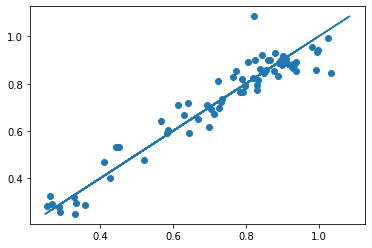

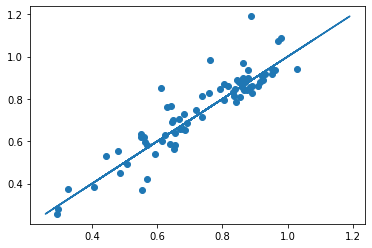

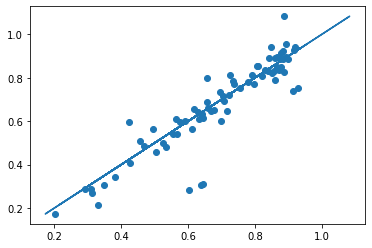

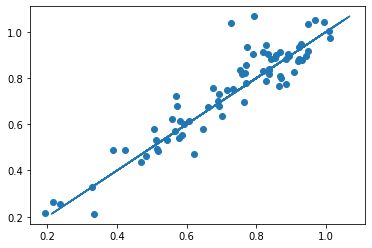

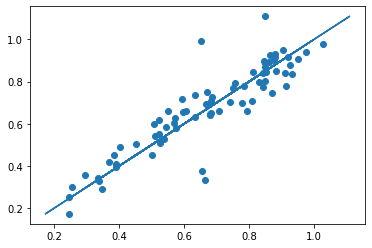

In [46]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
# KRR
RMSE = []
MAPE = []
training_time = []
for k in range(5):
    train_indices = shuffled_indices[:k*75] + shuffled_indices[(k+1)*75:]
    # train_indices = shuffled_indices[:5]
    test_indices = shuffled_indices[k*75: (k+1)*75]
    train_set = create_data_dict(data, train_indices, max_VOD, max_EVI)
    test_set = create_data_dict(data, test_indices, max_VOD, max_EVI)

    # form dataset with centroids
    keys = list(train_set.keys())
    train_bag = MultiResolutionBagDataGenerator(train_set)
    train_bag.y = train_bag.y
    
    x1 = np.zeros((0, train_bag.dim_1))
    x2 = np.zeros((0, train_bag.dim_2))
    for i, bag in enumerate(train_bag.bags):
        if train_bag[bag][1] < 10:
            num_VOD = train_bag[bag][1]
        else:
            num_VOD = 10
        x1 = np.vstack([x1, train_bag[bag][-3][:num_VOD]])
        x2 = np.vstack([x2, train_bag[bag][-2][:num_VOD]])
    x1_distances = scipy.spatial.distance.pdist(x1, metric='euclidean')
    x2_distances = scipy.spatial.distance.pdist(x2, metric='euclidean')
    x1_median = np.quantile(x1_distances, 0.5)
    x2_median = np.quantile(x2_distances, 0.5)
    
    k1 = gpflow.kernels.SquaredExponential(lengthscales=x1_median)
    k2 = gpflow.kernels.SquaredExponential(lengthscales=x2_median)
#     k1 = gpflow.kernels.Linear()
#     k2 = gpflow.kernels.Linear()
    krr = MultiResolutionKRRe(train_bag, k1, k2)
    t0 = time.time()
    krr.fit(median_heuristic=True)
    t1 = time.time()
    test_bag = MultiResolutionBagDataGenerator(test_set)
    test_bag.y = test_bag.y
    fstar_krr = krr.predict(test_bag)
    plt.figure()
    plt.scatter(fstar_krr, test_bag.y)
    plt.plot(test_bag.y, test_bag.y) 
    print("RMSE: ", np.sqrt(np.mean((fstar_krr - test_bag.y)**2)))
    training_time.append(t1-t0)
    MAPE.append(np.mean(np.abs(( fstar_krr - test_bag.y ) / test_bag.y)))
    RMSE.append(np.sqrt(np.mean((fstar_krr - test_bag.y)**2)))
print(f"CV-RMSE: {sum(RMSE) / 5}, CV-MAPE: {sum(MAPE) / 5}, Training Time: {sum(training_time)/5}")

In [47]:
{"CV-RMSE": sum(RMSE) / 5, "CV-MAPE": sum(MAPE) / 5, 
                       "CV-sd-RMSE": sem(RMSE), "CV-sd-MAPE": sem(MAPE),
                        "Training Time": sum(training_time)/5, "Training Time se": sem(training_time)}


{'CV-RMSE': 0.07917266243273868,
 'CV-MAPE': 0.0888116361922392,
 'CV-sd-RMSE': 0.005142646063436449,
 'CV-sd-MAPE': 0.00828499909050693,
 'Training Time': 1136.0162415981292,
 'Training Time se': 5.463243326210374}

In [48]:
json_file = json.dumps({"CV-RMSE": sum(RMSE) / 5, "CV-MAPE": sum(MAPE) / 5, 
                       "CV-sd-RMSE": sem(RMSE), "CV-sd-MAPE": sem(MAPE),
                        "Training Time": sum(training_time)/5, "Training Time se": sem(training_time)}
)
f = open('../../results/dr_paper/KRRe_CV.json', "w")
f.write(json_file)
f.close()